In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import datetime
import csv
import math
import time
from ProgressBar import ProgressBar

import nltk
import string
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import Lasso

/Users/kshain/anaconda/envs/AC209/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


The raw output from the NY Times API is stored as separate csv files for each year. We currently have all the data from 1997 onwards, but will just show a subset as an example here. The data includes the date of publication, article id, headline, and lead paragraph. We then stem the lead paragragh to increase the accuracy of the bag of words by eliminating meaningless variations of a word.

In [17]:
all_data_list = []
for year in range(1997,2007):
    data = pd.read_csv('{}_Output.csv'.format(year), header=None)
    all_data_list.append(data) # list of dataframes
data = pd.concat(all_data_list, axis=0)
data.columns = ['id','date','headline', 'lead']
data['yearmonth'] = map(lambda x: x[:7], data.date)

In [18]:
def getStems(lead):
    stemmer = nltk.stem.SnowballStemmer("english")
    tokens = nltk.word_tokenize(''.join(ch for ch in lead if ch not in set(string.punctuation)))
    return map(lambda x: stemmer.stem(x.decode('utf-8')), tokens)

In [19]:
def joinstems(stemlist):
    return ' '.join(stem for stem in stemlist)

In [20]:
stems = map(getStems, data.lead)

In [21]:
data['leadstems'] = map(joinstems, stems)

In [22]:
data.head()

,id,date,headline,lead,yearmonth,leadstems
0,52b86fb738f0d86bcb2a4e19,1997-01-01T00:00:00Z,Horizon Settles Billing Inquiry,The Horizon/CMS Health Care Corporation said t...,1997-01,the horizoncm health care corpor said today th...
1,4fd1f8368eb7c8105d753f3b,1997-01-08T00:00:00Z,Texaco Witness Is Said to Be Talking to U.S.,The central figure in the Texaco scandal has b...,1997-01,the central figur in the texaco scandal has be...
2,4fd1f8368eb7c8105d753f41,1997-01-08T00:00:00Z,14 sound stages will be built on speculation s...,A DEVELOPMENT partnership has acquired a site ...,1997-01,a develop partnership has acquir a site in thi...
3,4fd1fcc98eb7c8105d75be6c,1997-01-08T00:00:00Z,More rental car drivers will have the option o...,GETTING lost may become less of a problem for ...,1997-01,get lost may becom less of a problem for mani ...
4,4fd1cd7c8eb7c8105d704a32,1997-01-08T00:00:00Z,DELTA AIR LINES TO REALIGN ITS ROUTES,Delta Air Lines Inc. said yesterday that it wo...,1997-01,delta air line inc said yesterday that it woul...


## Count vectorizing
We will perform topic modeling as a means of feature reduction. Using individual stems as the features led to a high dimensional problem where none of the stems were correlated with CCI beyond the noise. Therefore, we will extract how much each document corresponds to a given topic and then try using those topics as the features to a model.

In [23]:
countVec = CountVectorizer(stop_words='english', max_df=0.8, min_df=.005, strip_accents='unicode')
wordMatrix = countVec.fit_transform(data.leadstems)
unigramVocab = countVec.get_feature_names()

In [24]:
lda = LatentDirichletAllocation(n_topics=10)
ldaDocs = lda.fit_transform(wordMatrix)

In [25]:
num_top_words = 10
topic_words = []

for topic in lda.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([unigramVocab[i] for i in word_idx])

In [26]:
topicDF = pd.DataFrame(topic_words)
topicDF.index = ['Topic {}'.format(i) for i in range(1,11)]
topicDF.columns = ['Stem {}'.format(i) for i in range(1,11)]
topicDF

,Stem 1,Stem 2,Stem 3,Stem 4,Stem 5,Stem 6,Stem 7,Stem 8,Stem 9,Stem 10
Topic 1,stock,percent,market,rate,price,week,investor,report,trade,index
Topic 2,bank,cut,euro,dollar,job,said,european,union,worker,japan
Topic 3,bond,rate,ago,buyer,10yr,music,tbill,sourc,500,percent
Topic 4,percent,said,million,year,share,sale,compani,quarter,cent,profit
Topic 5,execut,chief,mr,new,compani,group,york,presid,offic,account
Topic 6,compani,said,feder,internet,file,court,secur,commiss,state,servic
Topic 7,oil,state,unit,china,govern,demand,price,countri,energi,gas
Topic 8,compani,said,million,billion,share,base,yesterday,unit,buy,offer
Topic 9,year,time,airlin,busi,like,say,peopl,week,new,mani
Topic 10,fund,comput,compani,drug,product,technolog,softwar,use,said,market


It is interesting that the topics we find seem to make some sense. You can see how some articles fall into more banking, stock market, technology, advertising, etc. so the topics reflect words from those subject areas.

## Group by month
Then, I'll group the articles by month and find the average topics by month.

In [27]:
grouped = data.groupby('yearmonth')

In [28]:
topicsByMonth = np.zeros((len(grouped.groups.keys()),ldaDocs.shape[1]))
for i, month in enumerate(np.sort(grouped.groups.keys())):
    topicsByMonth[i] = np.mean(ldaDocs[grouped.get_group(month).index], axis=0)

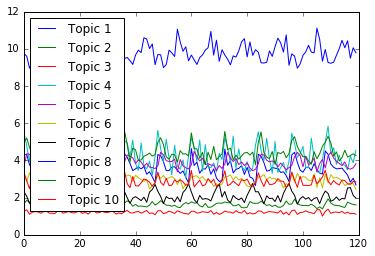

In [29]:
for topic in range(topicsByMonth.shape[1]):
    plt.plot(topicsByMonth[:,topic], label='Topic {}'.format(topic+1))
plt.legend(loc='best')

We can see that the topics are highly seasonal, as one might expect. Therefore, it is probably a good idea to include the topics lagged by 12 months in our final model.